Read each line and generate datapoint

In [1]:
import re #regexp
import sys
import random
import csv
import numpy as np
import pickle
import keras as k
from matplotlib import pyplot as plt
csv.field_size_limit(999999999)

import warnings
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [2]:
Type = {"fake": "fake", "rumor":"fake", "satire":"fake", "conspiracy":"fake", "junksci":"fake", "hate":"fake", "unreliable":"fake", "clickbait":"clickbait", "political":"valid", "reliable":"valid",  "bias":"bias"}

Count = {"fake": 15000, "rumor":5000, "satire":5000, "conspiracy":5000, "junksci":5000, "hate":5000, "unreliable":10000, "clickbait":50000, "political":25000, "reliable":25000, "bias":50000}


1. Download FakeNewsCorpus data from https://github.com/several27/FakeNewsCorpus?tab=readme-ov-file
2. Dowanload all files and then unzip any one file.
3. Download Glove embeddings from https://www.kaggle.com/datasets/watts2/glove6b50dtxt

In [ ]:
count = 0
with open('./out.csv', 'w', newline='') as out:
    with open('./news.csv/news_cleaned_2018_02_13.csv', encoding='utf8') as file:
        reader = csv.reader(file)
        writer = csv.writer(out)
        for r in reader:
            if(count == 200000):
                break
            if len(r) == 17:
                #title->9, content->5, type->3
                title = r[9]
                content = r[5]
                classification = r[3]
                #remove urls
                title = re.sub(r"http\S+",'', title)
                content = re.sub(r"http\S+",'', content)
                #remove non-alfa-numeric and stopwords.
                title = [word.lower() for word in tokenizer.tokenize(title) if word.isalpha() and not word.lower() in stop_words]
                content = [word.lower() for word in tokenizer.tokenize(content) if word.isalpha() and not word.lower() in stop_words]
                #change classification and write
                if len(title) != 0 and len(content) != 0:
                    if classification in Type.keys():
                        if Count[classification]: 
                            try:
                                writer.writerow([ " ".join(title),  " ".join(content), Type[classification]])
                                Count[classification] -= 1
                                print(count)
                                count += 1
                            except:
                                pass

Read processed data and generate embeddings

In [4]:
#0 -> title; 1 -> content; 2 -> type
title_length = {}
content_length = {}
data = []
with open('./out.csv') as file:
        reader = csv.reader(file)
        for r in reader:
                data.append(r)
                if len(r[0].split()) in title_length.keys():
                        title_length[len(r[0].split())] += 1
                else:
                        title_length[len(r[0].split())] = 1
                if len(r[1].split()) in content_length.keys():
                        content_length[len(r[1].split())] += 1
                else:
                        content_length[len(r[1].split())] = 1
random.shuffle()

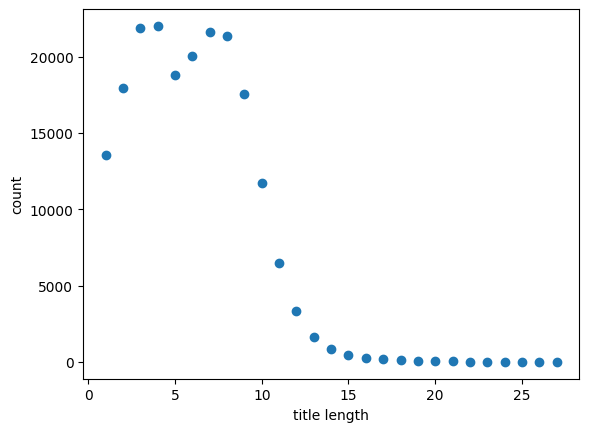

In [5]:
import matplotlib.pylab as plt
plt.scatter(title_length.keys(), title_length.values())
plt.xlabel('title length')
plt.ylabel('count')
plt.show()

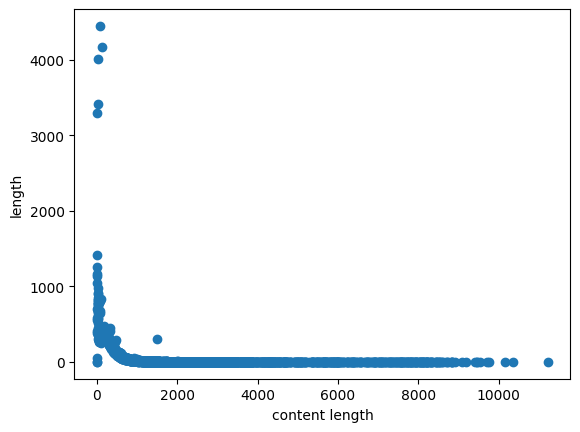

In [8]:
plt.scatter(content_length.keys(), content_length.values())
plt.xlabel('content length')
plt.ylabel('length')
plt.show()

In [12]:
embeddings_dict = {}
with open("glove.6B.50d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [ ]:
#create empty folder with name data in current directory
one_hot_encoding = np.eye(4)
classes = {'fake':0, 'clickbait':1, 'valid':2, 'bias':3}
dbfile = open('examplePickle', 'wb')
words = embeddings_dict.keys()
for i in range(100):
    dbfile = open('./data/pickle-' + str(i), 'wb')
    for j in range(2000):
        #title
        title = data[2000*i + j][0].split()
        if len(title)<=15:
            title = [embeddings_dict[t] if t in words else np.zeros(50) for t in title]
            title = np.pad(title, ((0,15-len(title)),(0,0)))
        else:
            title = [embeddings_dict[t] if t in words else np.zeros(50) for t in title[:15]]
        #content
        content = data[2000*i + j][0].split()
        if len(content)<=1600:
            content = [embeddings_dict[t] if t in words else np.zeros(50) for t in content]
            content = np.pad(content, ((0,1600-len(content)),(0,0)))
        else:
            content = [embeddings_dict[t] if t in words else np.zeros(50) for t in content[:1600]]
        #one hot encode type
        classification = one_hot_encoding[classes[data[2000*i + j][2]]]
        #append to dataset
        pickle.dump([title,content,classification], dbfile)
dbfile.close()

In [217]:
class DataGenerator(k.utils.Sequence):
    def __init__(self,list_IDs):
        self.list_IDs = list_IDs
        self.on_epoch_end()

    def __len__(self):
        return len(self.list_IDs)
    
    def on_epoch_end(self):
        np.random.shuffle(self.list_IDs)
    
    def __getitem__(self, index):
        # Generate data
        file = open(self.list_IDs[index], "rb")
        x1 = np.empty((2000,15,50))
        x2 = np.empty((2000,1600,50))
        y = np.empty((2000,4))
        for i in range(2000):
            data = pickle.load(file)
            x1[i] = data[0]
            x2[i] = data[1]
            y[i] = data[2]
        return (x1, x2), y

In [146]:
#input_title
title_input = k.layers.Input(shape=(15,50,), name='title_input')

x = k.layers.Conv1D(filters = 5, kernel_size=4, strides=2, activation='relu', name='Conv1Title')(title_input)
x = k.layers.MaxPool1D(pool_size = 2, name='Pool1Title')(x)
x = k.layers.Flatten()(x)
x = k.layers.Dense(50, activation='relu', name='Dense1Title', kernel_regularizer='l2')(x)

#input_content
content_input = k.layers.Input(shape=(1600,50,), name='content_input')
x2 = k.layers.Conv1D(filters = 80, kernel_size = 16, strides = 4, activation='relu', name='Conv2Content')(content_input)
x2 = k.layers.MaxPool1D(pool_size = 4, name='Pool2Content')(x2)
x2 = k.layers.Flatten()(x2)
x2 = k.layers.Dense(100, activation='relu', kernel_regularizer='l2', name='Dense1Content')(x2)

#Merge
x = k.layers.concatenate([x, x2])

#Common part
x = k.layers.Dense(50, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)
x = k.layers.Dense(50, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)
out = k.layers.Dense(4, activation='softmax')(x)

model = k.models.Model(inputs=[title_input, content_input], outputs=[out])
model.compile(k.optimizers.RMSprop(), loss='categorical_crossentropy', metrics=['acc'])

In [147]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ title_input (InputLayer)      │ (None, 15, 50)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ content_input (InputLayer)    │ (None, 1600, 50)          │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1Title (Conv1D)           │ (None, 6, 5)              │           1,005 │ title_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv2Content (Conv1D)         │ (None, 397, 80)           │          64,080 │ content_input[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Pool1Title (MaxPooling1D)     │ (None, 3, 5)              │               0 │ Conv1Title[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Pool2Content (MaxPooling1D)   │ (None, 99, 80)            │               0 │ Conv2Content[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_6 (Flatten)           │ (None, 15)                │               0 │ Pool1Title[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_7 (Flatten)           │ (None, 7920)              │               0 │ Pool2Content[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Dense1Title (Dense)           │ (None, 50)                │             800 │ flatten_6[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Dense1Content (Dense)         │ (None, 100)               │         792,100 │ flatten_7[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_3 (Concatenate)   │ (None, 150)               │               0 │ Dense1Title[0][0],         │
│                               │                           │                 │ Dense1Content[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_9 (Dense)               │ (None, 50)                │           7,550 │ concatenate_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_6 (Dropout)           │ (None, 50)                │               0 │ dense_9[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_10 (Dense)              │ (None, 50)                │           2,550 │ dropout_6[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_7 (Dropout)           │ (None, 50)                │               0 │ dense_10[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_11 (Dense)              │ (None, 4)                 │             204 │ dropout_7[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 868,289 (3.31 MB)

 Trainable params: 868,289 (3.31 MB)

 Non-trainable params: 0 (0.00 B)

In [220]:
h = model.fit(DataGenerator(["./data/pickle-"+str(i) for i in range(95)]), 
              validation_data = DataGenerator(["./data/pickle-"+str(i) for i in [96,97,98]]), 
              epochs=10)

Epoch 1/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 323s 3s/step - acc: 0.4392 - loss: 2.0150 - val_acc: 0.6362 - val_loss: 0.9704
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 315s 3s/step - acc: 0.6361 - loss: 0.9666 - val_acc: 0.6650 - val_loss: 0.8517
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 316s 3s/step - acc: 0.6828 - loss: 0.8323 - val_acc: 0.7093 - val_loss: 0.7559
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 319s 3s/step - acc: 0.7128 - loss: 0.7575 - val_acc: 0.7315 - val_loss: 0.7282
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 315s 3s/step - acc: 0.7335 - loss: 0.7197 - val_acc: 0.7330 - val_loss: 0.7001
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 317s 3s/step - acc: 0.7537 - loss: 0.6828 - val_acc: 0.7263 - val_loss: 0.7237
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 315s 3s/step - acc: 0.7669 - loss: 0.6544 - val_acc: 0.7505 - val_loss: 0.6801
Epoch 8/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 321s 3s/step - acc: 0.7816 - loss: 0.6283 - val_acc: 0.7582 - val_loss: 0.6705
Epoch 9/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 317s 3s/step - acc: 0.7933

In [223]:
x1 = np.empty((4000,15,50))
x2 = np.empty((4000,1600,50))
y = np.empty((4000,4))
file = open("./data/pickle-95", "rb")
for i in range(2000):
    data = pickle.load(file)
    x1[i] = data[0]
    x2[i] = data[1]
    y[i] = data[2]
file = open("./data/pickle-99", "rb")
for i in range(2000):
    data = pickle.load(file)
    x1[2000+i] = data[0]
    x2[2000+i] = data[1]
    y[2000+i] = data[2]
x = [x1, x2]

In [228]:
model.evaluate(x,y)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.7478 - loss: 0.6932


[0.7011516690254211, 0.7487499713897705]

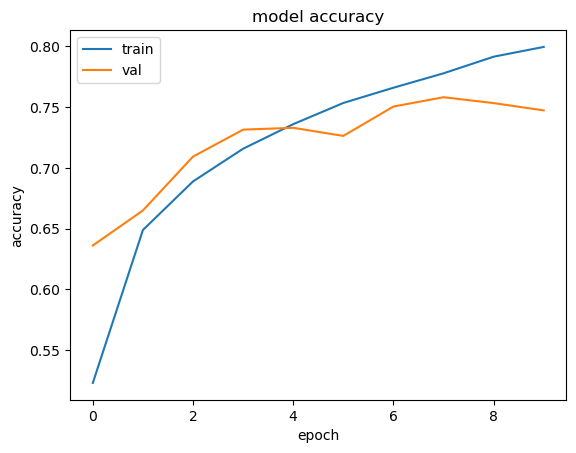

In [233]:
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [234]:
model.save("./cnn-model.keras")